### Setup Instructions

Please follow the [setup instructions](/docs/cv-tutorial-setup) to prepare your environment if you haven't yet.   
This tutorial will be referencing this [Notebook](https://github.com/outerbounds/tutorials/blob/main/cv/cv-intro-1.ipynb).

In this tutorial you will build a workflow to create image classification models. 
We use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) which comes packaged with Keras. 
MNIST is a classic dataset that is small enough that you should be able to run this entire tutorial on your laptop.
This makes it useful for an interactive tutorial, however it is not the most realistic use case for Metaflow.
Metaflow is most useful when projects have onerous scaling requirements, are mission critical, and/or have many interacting parts. You can read more here: [Should I Use Metaflow?](https://docs.metaflow.org/introduction/what-is-metaflow#should-i-use-metaflow)

:::note
Metaflow helps you structure data-driven code so it scales from your data science workstation to reproducible cloud environments.
:::

Here is what the data looks like:

In [1]:
from tensorflow import keras
import numpy as np

num_classes = 10
((x_train, y_train), (x_test, y_test)) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

You will find 60000 and 10000 data instances (images) in the training and test set. 
Each image has dimensions `28x28x1`. 

In [2]:
# show dataset dimensionality
print("Train Set Feature Dimensions: {}".format(x_train.shape), end = " | ")
print("Train Set Label Dimensions: {}".format(y_train.shape))
print("Test Set Feature Dimensions: {}".format(x_test.shape), end = " | ")
print("Test Set Label Dimensions: {}".format(y_test.shape))

Train Set Feature Dimensions: (60000, 28, 28, 1) | Train Set Label Dimensions: (60000, 10)
Test Set Feature Dimensions: (10000, 28, 28, 1) | Test Set Label Dimensions: (10000, 10)


The images are of hand written digits that look like this:

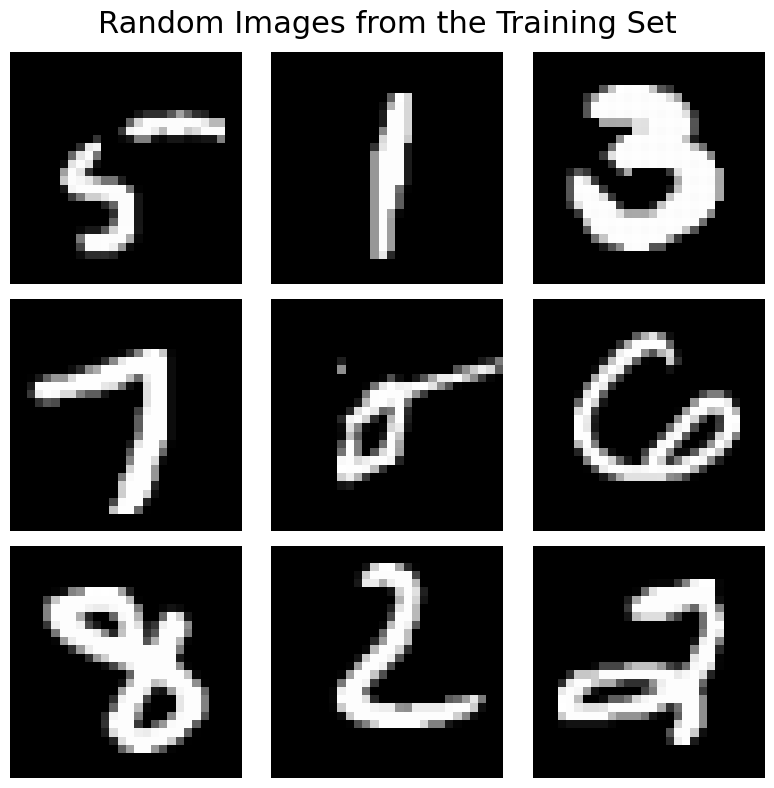

In [3]:
#meta:tag=hide_output
import matplotlib.pyplot as plt

N_ROWS = N_COLS = 3
out_path = './mnist_random_image_grid.png'

fig,ax = plt.subplots(N_ROWS, N_COLS, figsize=(8,8))
for i in range(N_ROWS):
    for j in range(N_COLS):
        idx = np.random.randint(low=0, high=x_train.shape[0])
        ax[i,j].imshow(x_train[idx], cmap='gray')
        ax[i,j].axis('off')
fig.suptitle("Random Images from the Training Set", fontsize=22, y=.98)
fig.tight_layout()
fig.savefig(out_path);

![](./mnist_random_image_grid.png)

The data instances in this dataset each have one label. 
The learning task is to predict the correct label out of the 10 possibilities. 
In the `y_train` and `y_test` objects, you will see 10 dimensions for each data instance. 
For each of these records, one of the ten dimensions will be a `1` and all others will be a `0`. 
You can verify this with the following assertion:

In [4]:
assert np.all(y_test.sum(axis=1) == 1)

Finally, the distribution over true class labels shows class balance. 

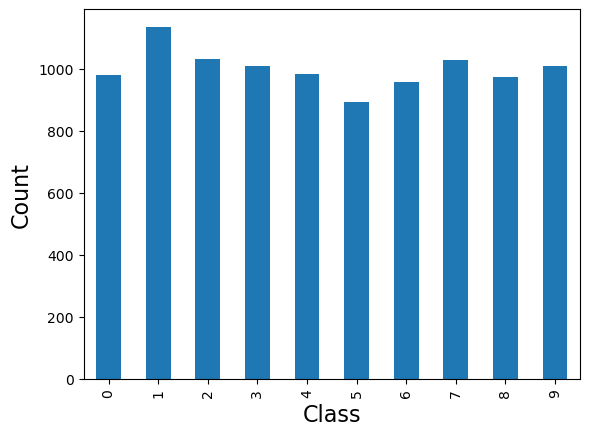

In [5]:
#meta:tag=hide_output
import pandas as pd
plot = pd.DataFrame(y_test).sum(axis=0).plot(kind='bar')
fig = plot.get_figure()
fig.gca().set_xlabel('Class', fontsize=16)
fig.gca().set_ylabel('Count', fontsize=16)
fig.savefig('./class-distribution.png')

![](./class-distribution.png)

Before training a model, it is useful to set a baseline. One baseline is the majority-class classifier, which measures what happens when all of data instances are predicted to be from the majority class (in the training set). This pattern is demonstrated in our [NLP tutorial](/docs/nlp-tutorial-overview/). However, for the MNIST dataset and the image classification task described above, the majority class-classifier will lead to a baseline model that predicts correctly just over 10% of the time. This is not a very useful baseline. Instead lets build a feedforward neural network to compare to a more advanced convolutional neural network you will build later.

First you can study the hyperparamters and Keras model dependencies. 

In [6]:
from tensorflow.keras import layers, Sequential, Input

num_pixels = 28 * 28
num_classes = y_test.shape[1]

kernel_initializer = 'normal'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

epochs = 3
batch_size = 32
verbose = 2

Next, lets construct a Keras model adding `layers`. 
The Keras `layers` apply matrix operations to data as it moves towards the output layer of the neural network.
In this case, we use two `Dense` layers. `Dense` means they are feed-forward, fully-connected layers. 

In [7]:
model = Sequential()
model.add(layers.Dense(
    num_pixels, input_dim=num_pixels,
    kernel_initializer=kernel_initializer,
    activation='relu'
))
model.add(layers.Dense(
    num_classes,
    kernel_initializer=kernel_initializer,
    activation='softmax'
))
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

To work with the feed-forward network you need to reshape the images. 
This is done by flattening the matrix representing the images into a one-dimensional vector with length `num_pixels`. 
Notice that this is the same value as the `input_dim` of the first `layer` in the neural network you defined in the last step. 
Once the data is ready, we can pass it to the `model.fit` function and train a neural network!

In [8]:
_x_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32')
_x_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')
history = model.fit(
    _x_train, y_train,
    validation_data = (_x_test, y_test),
    epochs = epochs,
    batch_size = batch_size,
    verbose = verbose
)

Epoch 1/3


2022-10-11 22:55:03.746993: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1875/1875 - 3s - loss: 0.1881 - accuracy: 0.9446 - val_loss: 0.0909 - val_accuracy: 0.9727 - 3s/epoch - 2ms/step
Epoch 2/3
1875/1875 - 3s - loss: 0.0747 - accuracy: 0.9772 - val_loss: 0.0755 - val_accuracy: 0.9755 - 3s/epoch - 1ms/step
Epoch 3/3
1875/1875 - 3s - loss: 0.0485 - accuracy: 0.9843 - val_loss: 0.0652 - val_accuracy: 0.9799 - 3s/epoch - 1ms/step


After training the model you will want to evaluate its performance to see if it's ability to generalize is improving:

In [9]:
scores = model.evaluate(
    x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2]).astype('float32'),
    y_test,
    verbose=0
)
categorical_cross_entropy = scores[0]
accuracy = scores[1]
msg = "The model predicted correctly {}% of the time on the test set."
print(msg.format(round(100*accuracy, 3)))

The model predicted correctly 97.99% of the time on the test set.


Keras provides utilities for saving and loading models as well. 
For example, you can save the model architecture, model weights, and the traced TensorFlow subgraphs of call functions with a simple `model.save` API. 

In [10]:
location = 'test_model'
model.save(location)

INFO:tensorflow:Assets written to: test_model/assets


Using `model.load` with the same location will then reload the same model object state:

In [11]:
new_model = keras.models.load_model(location)
scores = model.evaluate(
    x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2]).astype('float32'),
    y_test,
    verbose=0
)
assert scores[1] > .96, "Model should be doing better after two epochs."

To learn more about your options for saving and loading Keras models please see [this guide](https://www.tensorflow.org/guide/keras/save_and_serialize). It describes cases like how to [save to the Keras H5 format](https://www.tensorflow.org/guide/keras/save_and_serialize#whole-model_saving_loading) instead of the newer SavedModel format and how to [save and load only model weights](https://www.tensorflow.org/guide/keras/save_and_serialize#saving_loading_only_the_models_weights_values).

In this lesson you explored the MNIST dataset and built a high-accuracy baseline model. In the next lesson, you will build a convolutional neural network model to see how its performance compares to the baseline. See you there! 